In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the titanic dataset

Available at : https://www.kaggle.com/c/titanic/data

In [2]:
titanic = pd.read_csv('Data/train.csv', index_col=0)
titanic_submission = pd.read_csv('Data/test.csv', index_col=0)

# 1. EDA

## 1.1 Quick check of the data

In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


We see that there is some missing values, let's see it in more details :

In [5]:
nan_count = titanic.isnull().sum().sort_values(ascending=False)
nan_count = nan_count[nan_count!=0]
nan_pct = nan_count/len(titanic)*100

nan_df = pd.DataFrame({'Nan_count':nan_count, 'Nan_pct':nan_pct.round(2)})
nan_df

,Nan_count,Nan_pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


* For the **Embarked** variable, only 2 values are missing, we could choose to drop these rows or to impute the mode (most frequent value) to these two rows.

* The **Age** variable has a lot of missing values, but we can't choose to drop it because it is an important feature, as we'll see.

* The **Cabin** variable must be dropped, it has way too much missing values.

Next, let's check if the Ticket variable can give us some useful information

In [6]:
# number of unique values for Ticket
titanic.Ticket.nunique()

681

In [7]:
# most frequent values for Ticket
titanic.Ticket.value_counts().head(10)

CA. 2343        7
1601            7
347082          7
CA 2144         6
3101295         6
347088          6
382652          5
S.O.C. 14879    5
PC 17757        4
LINE            4
Name: Ticket, dtype: int64

We see that we won't get anything useful from this variable, we can drop it.

### Survived frequency count

In [8]:
titanic.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

It's always important to check if the value counts of the target variable are not too unbalanced. Here, it's not too unbalanced.

## 1.2 Data visualisation

In [9]:
# I do a copy of the dataset, to experiment some transformation on the copy
df = titanic.copy()
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Pclass and Sex

It's quite obvious to think that the higher class passengers were more likely to survive, let's check it.

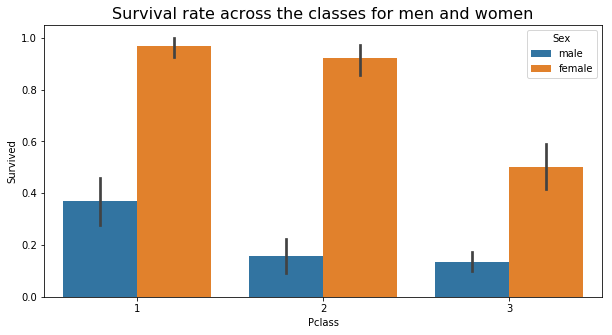

In [10]:
plt.figure(figsize=(10,5))
sns.barplot('Pclass', 'Survived', data=df, hue='Sex')
plt.title('Survival rate across the classes for men and women', fontsize=16);

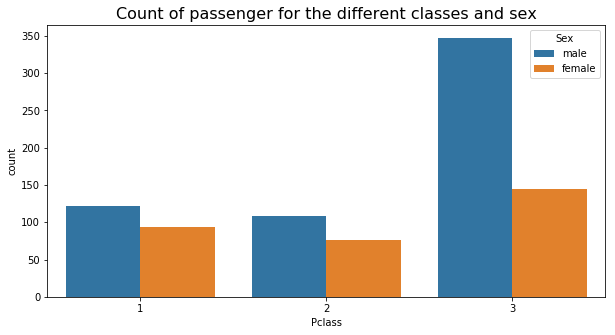

In [11]:
plt.figure(figsize=(10,5))
sns.countplot('Pclass', data=df, hue='Sex')
plt.title('Count of passenger for the different classes and sex', fontsize=16);

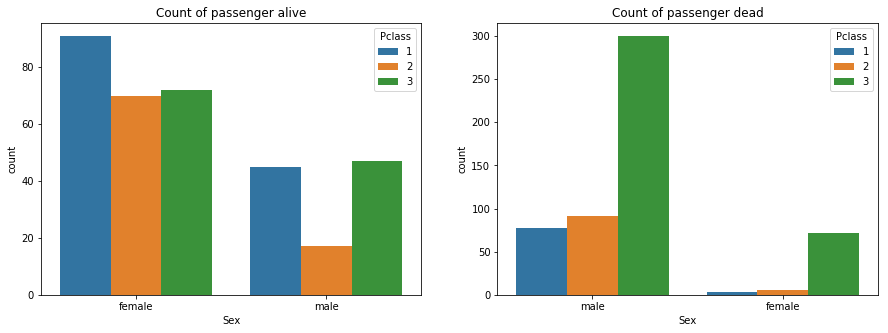

In [12]:
survived_df = df.query('Survived==1')
dead_df = df.query('Survived==0')

fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,5)

sns.countplot('Sex', data=survived_df, hue='Pclass', ax=axes[0])
sns.countplot('Sex', data=dead_df, hue='Pclass', ax=axes[1])

axes[0].set_title('Count of passenger alive')
axes[1].set_title('Count of passenger dead');

We can see from these plots (particularly, the first one, about the rate of survival), that class and sex were very important about the survival rate of the passengers. An other clear display of this, is the frequency table, below.

In [13]:
df.groupby(['Pclass', 'Sex']).Survived.mean().unstack()

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


An interesting question to ask ourselve : What is the accuracy of our prediction if we state that every women survived, and every men died ?

In [14]:
simple_prediction = df.Sex == 'female'

simple_prediction_acc = (simple_prediction == df.Survived).mean()
simple_prediction_acc

0.78675645342312006

Incredible ! 78 % of our predictions are right ! But this value isn't right, because our accuracy is measured on the same dataset used to make our simple model. We can get a better measure of the accuracy of this model by applying it to the test set for the Kaggle competition, and check the result.

In [15]:
titanic_submission_pred = (titanic_submission.Sex == 'female')*1

submission_df = pd.DataFrame({'Survived': titanic_submission_pred})
submission_df.to_csv('Data/simple_submission.csv')

This submission get us 0.76555 of accuracy score. We can use this as a landmark, any model not giving better results than this, is just crap... if the goal is plain and simple accuracy.

### Embarked

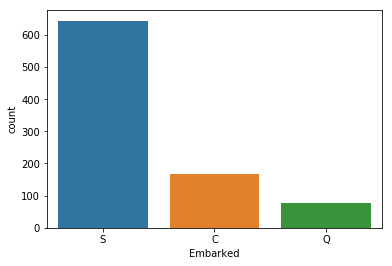

In [16]:
sns.countplot(df.Embarked);

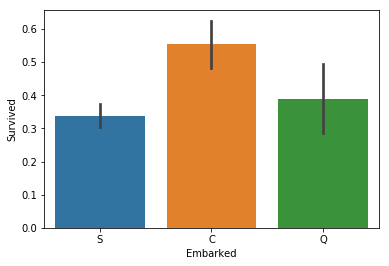

In [17]:
sns.barplot('Embarked', 'Survived', data=df);

It's clear that there is a significant difference of the survival rate across the three Embarked groups, but it's not so clear if the survival rate for Q is significantly different than for C and S. We can do an independant t-test to check this.

In [18]:
from scipy.stats import ttest_ind

def multiple_ind_ttest(groups_dict):
    '''
    input : dictionnary of groups to be indenpent t-tested 
            keys : string : name of group
            values : groups (list, array or serie)
    --------------------
    output : DataFrame with t statistic and p-value
    '''
    keys = list(groups_dict.keys())
    t_test_df = pd.DataFrame(columns=['t', 'p'])

    for i, group_1 in enumerate(keys):
        for group_2 in keys[i+1:]:
            if group_1 != group_2:
                t, p = ttest_ind(groups_dict[group_1], groups_dict[group_2])
                t_test_df.loc[group_1+'_'+group_2, 't'] = t
                t_test_df.loc[group_1+'_'+group_2, 'p'] = p
    
    return t_test_df.sort_values(by='p')

S_survived = df.loc[df['Embarked']=='S', 'Survived']
C_survived = df.loc[df['Embarked']=='C', 'Survived']
Q_survived = df.loc[df['Embarked']=='Q', 'Survived']

groups_dict = {'S':S_survived, 'C':C_survived, 'Q':Q_survived}

multiple_ind_ttest(groups_dict)

,t,p
S_C,-5.22634,2.20144e-07
C_Q,2.40106,0.0171001
S_Q,-0.919392,0.358199


There is no significant difference of survival rate between the group **S** and **Q**, so, we could choose to fuse these two categories together.

### Age

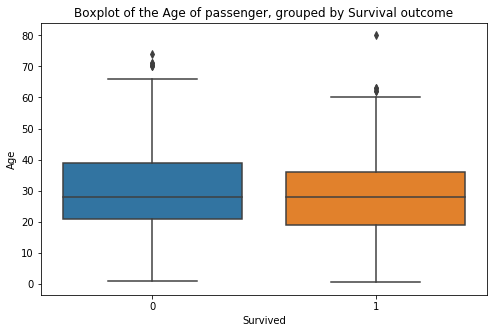

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot('Survived', 'Age', data=df)
plt.title('Boxplot of the Age of passenger, grouped by Survival outcome');

This doesn't show any significant difference in the distribution of Age, for the two Survived groups.

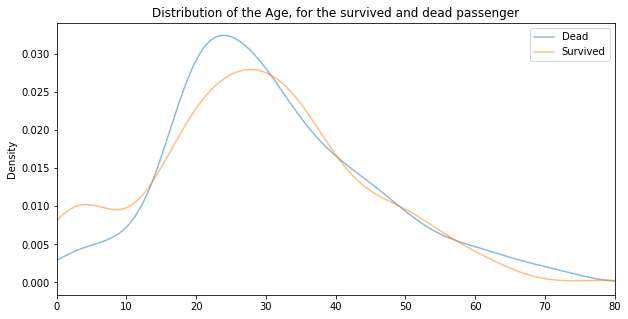

In [20]:
plt.figure(figsize=(10,5))
df.groupby('Survived').Age.plot(kind='kde', alpha=0.5)
plt.xlim([0,80])
plt.legend(['Dead','Survived'])
plt.title('Distribution of the Age, for the survived and dead passenger');

We see that above ~35 years, the distribution is very similar for the two outcome. We could transform this numerical variable into a categorical variable, by binning it, for example : [0,15), [15,30),[30,)

### Fare

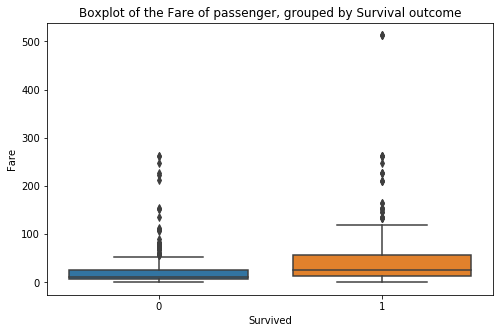

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot('Survived', 'Fare', data=df)
plt.title('Boxplot of the Fare of passenger, grouped by Survival outcome');

There is a lot of outliers, let's change the y limit of the plot to have a better view of the distribution.

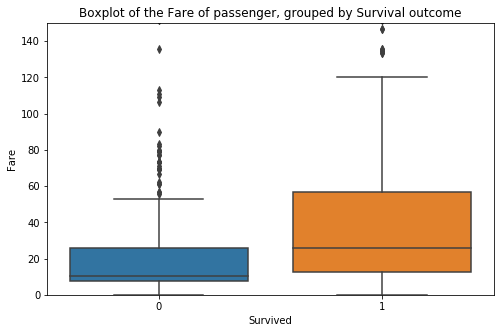

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot('Survived', 'Fare', data=df)
plt.ylim([0,150])
plt.title('Boxplot of the Fare of passenger, grouped by Survival outcome');

There is a clear difference, people who survived paid an higher fare.

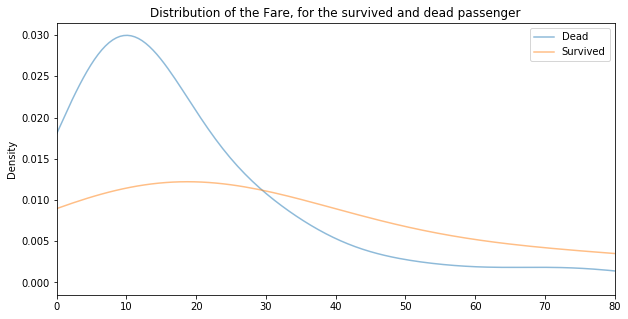

In [23]:
plt.figure(figsize=(10,5))
df.groupby('Survived').Fare.plot(kind='kde', alpha=0.5)
plt.xlim([0,80])
plt.legend(['Dead','Survived'])
plt.title('Distribution of the Fare, for the survived and dead passenger');

We could transform this variable into a categorical one, with bins : [0,30), [30,)

### SibSp and Parch

**SibSp** and **Parch** refers respectively to the numbers of siblings/spouses aboard the Titanic and the number of parents/children aboard the Titanic.

It's not very obvious at first think if these variable are useful, let's explore it.

In [24]:
df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
df.groupby('SibSp').Survived.mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [26]:
df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [27]:
df.groupby('Parch').Survived.mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

We see some difference in survival rate between values of 0 and 1 or more for the variables **SibSp** and **Parch**. It could be interesting to add them together.

In [28]:
df['Relatives'] = df.Parch + df.SibSp
df.Relatives.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Relatives, dtype: int64

In [29]:
df.groupby(by='Relatives').Survived.mean()

Relatives
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

Let's do a t-test to help us how to group these different values.

In [30]:
# t-test
relatives_dict = {}
for i in range(4):
    relatives_dict['rel_'+str(i)] = df.loc[df.Relatives == i, 'Survived']

multiple_ind_ttest(relatives_dict)

,t,p
rel_0_rel_1,-5.91042,5.34307e-09
rel_0_rel_2,-5.46021,6.82276e-08
rel_0_rel_3,-4.79663,2.06794e-06
rel_1_rel_3,-1.72474,0.0862171
rel_2_rel_3,-1.42008,0.157998
rel_1_rel_2,-0.406956,0.684374


I think it's a good idea to discard both **SibSp** and **Parch**, because they both show a similar distribution, and keep only the new variable **Relatives**. We see for **Relatives** that the difference in survival rate is significant mostly for the value 0 vs the other value. We can change values to two categories : alone (0) and accompanied (values 1 and higher).

### Name

The only thing that could be useful here, is the title. The family wouldn't not be a good predictor, unless there is some very large families who all drown or survived together.

In [31]:
df.Name.head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

In [32]:
def get_title(name):
    try:
        name_list = name.split(sep=', ')
        name_list2 = name_list[1].split(sep='.')
        title = name_list2[0]
    except:
        title='None'
    
    return title

titles = df.Name.map(get_title)
titles.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Jonkheer          1
Ms                1
Lady              1
Sir               1
Mme               1
the Countess      1
Capt              1
Don               1
Name: Name, dtype: int64

We see 4 titles frequent enough to be used as categorical predictors, let's see if they have an effect on survival rate.

In [33]:
# First I redefine the previous function to change less frequent title into a new category 
def get_title_2(name):
    try:
        name_list = name.split(sep=', ')
        name_list2 = name_list[1].split(sep='.')
        title = name_list2[0]
    except:
        title = 'None'
    
    if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title = 'None'
    
    return title

titles = df.Name.map(get_title_2)
titles.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
None       27
Name: Name, dtype: int64

In [34]:
df['Title'] = titles
df.groupby('Title').Survived.mean()

Title
Master    0.575000
Miss      0.697802
Mr        0.156673
Mrs       0.792000
None      0.444444
Name: Survived, dtype: float64

T-test

In [35]:
master = df.loc[df.Title == 'Master', 'Survived']
miss = df.loc[df.Title == 'Miss', 'Survived']
mr = df.loc[df.Title == 'Mr', 'Survived']
mrs = df.loc[df.Title == 'Mrs', 'Survived']
none = df.loc[df.Title == 'None', 'Survived']

title_dict = {'Master':master, 'Miss':miss, 'Mr':mr, 'Mrs':mrs, 'None':none}

multiple_ind_ttest(title_dict)

,t,p
Mr_Mrs,-17.1027,2.74423e-54
Miss_Mr,16.0473,1.49776e-49
Master_Mr,6.7956,2.7892e-11
Mr_None,-3.91934,0.000100161
Mrs_None,3.84178,0.000179816
Master_Mrs,-2.76755,0.00630152
Miss_None,2.63352,0.00908843
Miss_Mrs,-1.84413,0.0661333
Master_Miss,-1.50311,0.134245
Master_None,1.04221,0.301177


We see that that the title can be used as a predictor, but we must not forget that *Mr*, *Mrs* and *Miss* are both very correlated to the **Sex** variable, which means that it could not be very useful to use the five categories we just created.

# 2. Data cleaning

We now define a set of function to clean and transform our dataset like we did in the EDA.

In [36]:
def fuse_cat_embarked(df):
    '''
    Fuse the values 'C' and 'S' into one category.
    '''
    df2 = df.copy()
    df2.loc[df2['Embarked']=='Q', 'Embarked'] = 'Q/S'
    df2.loc[df2['Embarked']=='S', 'Embarked'] = 'Q/S'
    return df2

def binning_age(df):
    '''
    Bin the Age variable into 3 bins : -inf, 15], (15,30], (30,inf
    '''
    df2 = df.copy()
    df2['Age'] = pd.cut(df2['Age'], [-np.inf,15,30, np.inf])
    return df2

def binning_fare(df):
    '''
    Bin the Fare variable : -inf,30], (30,inf
    '''
    df2 = df.copy()
    df2['Fare'] = pd.cut(df2['Fare'], [-np.inf, 30, np.inf])
    return df2

def relatives_transf(df):
    '''
    Transform the Parch and SibSp variable into one categorical variable Relatives,
    with only two categories 0 : alone, 1 : not alone.
    '''
    df2 = df.copy()
    df2['Relatives'] = df2.Parch + df2.SibSp
    df2['Relatives'] = df2['Relatives'].where(df2['Relatives']==0, 1)
    
    df2 = df2.drop(['Parch', 'SibSp'], axis=1)
    return df2

def title_transf(df):
    '''
    Transform the Name variable into a new variable, Title, with 5 possible values : ['Mr', 'Miss', 'Mrs', 'Master', 'None]
    '''
    def get_title_2(name):
        '''
        Get the title from a name of a passenger of the Titanic
        Return a value from ['Mr', 'Miss', 'Mrs', 'Master', 'None]
        '''
        try:
            name_list = name.split(sep=', ')
            name_list2 = name_list[1].split(sep='.')
            title = name_list2[0]
        except:
            title = 'None'

        if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
            title = 'None'

        return title
    df2 = df.copy()
    
    titles = df2.Name.map(get_title_2)
    df2['Title'] = titles
    df2 = df2.drop(['Name'], axis=1)
    
    return df2

def drop_cols(df, cols=['Ticket', 'Cabin']):
    '''
    Drop the columns in the list cols
    '''
    df2 = df.copy()
    df2 = df2.drop(cols, axis=1)
    return df2


def apply_functions(df, funcs):
    df2 = df.copy()
    for func in funcs:
        df2 = func(df2)
    return df2

funcs_list = [fuse_cat_embarked, binning_age, binning_fare, relatives_transf, title_transf, drop_cols]

df_clean = apply_functions(titanic, funcs=funcs_list)
df_clean.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives,Title
PassengerId,,,,,,,,
1,0,3,male,"(15.0, 30.0]","(-inf, 30.0]",Q/S,1,Mr
2,1,1,female,"(30.0, inf]","(30.0, inf]",C,1,Mrs
3,1,3,female,"(15.0, 30.0]","(-inf, 30.0]",Q/S,0,Miss
4,1,1,female,"(30.0, inf]","(30.0, inf]",Q/S,1,Mrs
5,0,3,male,"(30.0, inf]","(-inf, 30.0]",Q/S,0,Mr


Great, but that's not over. We still need to replace some missing values and change the categorical variables into dummies variables. 

### Nans 

We still have some nans to take care of.

In [37]:
df_clean_nans = df_clean.isnull().sum()
df_clean_nans[df_clean_nans!=0]

Age         177
Embarked      2
dtype: int64

In [38]:
df_clean.Age.value_counts()

(15.0, 30.0]    326
(30.0, inf]     305
(-inf, 15.0]     83
Name: Age, dtype: int64

What could we do for the Age variable here ? We could impute the most frequent category ((15.0, 30.0], here), or create a new category.

In [39]:
age_mode = df_clean.Age.value_counts().index[0]
def age_imputer(df, mode=age_mode, nan_strat=False):
    '''
    Replace the nan value of the variable Age by either the mode (if nan_strat=False), 
    or either the value 'nan(if nan_strat=True).
    '''
    df2 = df.copy()
    age = df2.Age
    if not nan_strat:
        age[df.Age.isnull()] = mode
    else:
        age = age.astype('object')
        age[df.Age.isnull()] = 'nan'
    df2.Age = age
    return df2

And for the Embarked nans, we can also impute the mode

In [40]:
embarked_mode = df_clean.Embarked.value_counts().index[0]
def embarked_imputer(df, mode=embarked_mode):
    df2 = df.copy()
    df2.loc[df2.Embarked.isnull(), 'Embarked'] = mode
    return df2

In [41]:
funcs_list = [fuse_cat_embarked, binning_age, binning_fare, relatives_transf, title_transf, drop_cols, age_imputer, embarked_imputer]

df_clean_no_nan = apply_functions(titanic, funcs=funcs_list)
df_clean_no_nan.isnull().any().any()

False

Great, our dataset is clean ! Let's check if our transformation works on both our train and test set.

In [42]:
apply_functions(titanic_submission, funcs=funcs_list).isnull().sum()

Pclass       0
Sex          0
Age          0
Fare         1
Embarked     0
Relatives    0
Title        0
dtype: int64

There is still a nan is the test set after all our transformation, let's define a last function to impute the mode on this missing value.

In [43]:
fare_mode = df_clean.Fare.value_counts().index[0]
def fare_imputer(df, mode=fare_mode):
    df2 = df.copy()
    df2.loc[df2.Fare.isnull(), 'Fare'] = mode
    return df2

In [44]:
funcs_list = [fuse_cat_embarked, binning_age, binning_fare, relatives_transf, title_transf, 
              drop_cols, age_imputer, embarked_imputer, fare_imputer]

df_clean_no_nan_submission = apply_functions(titanic_submission, funcs=funcs_list)
df_clean_no_nan_submission.isnull().any().any()

False

### Last step of preparation of our data : dummy variables

To make our categorical variables useable to our models, we need to change these variables into dummy variables.

In [45]:
funcs_list = [fuse_cat_embarked, binning_age, binning_fare, relatives_transf, title_transf, 
              drop_cols, age_imputer, embarked_imputer, fare_imputer]

df_clean_no_nan = apply_functions(titanic, funcs=funcs_list)
# reprint the first rows our clean dataset
df_clean_no_nan.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives,Title
PassengerId,,,,,,,,
1,0,3,male,"(15.0, 30.0]","(-inf, 30.0]",Q/S,1,Mr
2,1,1,female,"(30.0, inf]","(30.0, inf]",C,1,Mrs
3,1,3,female,"(15.0, 30.0]","(-inf, 30.0]",Q/S,0,Miss
4,1,1,female,"(30.0, inf]","(30.0, inf]",Q/S,1,Mrs
5,0,3,male,"(30.0, inf]","(-inf, 30.0]",Q/S,0,Mr


In [46]:
#check the dtype of each variable
df_clean_no_nan.dtypes

Survived        int64
Pclass          int64
Sex            object
Age          category
Fare         category
Embarked       object
Relatives       int64
Title          object
dtype: object

In [47]:
# Change the object variable into categorical variable
df_clean_no_nan_copy = df_clean_no_nan.copy()
for col in ['Pclass', 'Sex', 'Embarked', 'Title']:
    df_clean_no_nan_copy[col] = df_clean_no_nan_copy[col].astype('category')
df_clean_no_nan_copy.dtypes

Survived        int64
Pclass       category
Sex          category
Age          category
Fare         category
Embarked     category
Relatives       int64
Title        category
dtype: object

Let's transform these categorical variable into dummy variable. For this, I define a transformer class.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class dummy_encoder(BaseEstimator, TransformerMixin):
    def __init__(self, drop_first=False):
        self.drop_first = drop_first
    def fit(self, X, y=None):
        dtypes = X.dtypes
        self.cols = X.loc[:, (dtypes == 'object')|(dtypes == 'category')].columns
        self.dummy_cols = pd.get_dummies(X, columns=self.cols, drop_first=self.drop_first).columns
        
        return self
    
    def transform(self, X):
        X_transformed = pd.get_dummies(X, columns=self.cols)
        X_transformed = X_transformed.reindex(columns=self.dummy_cols, fill_value=0)
        
        return X_transformed

In [49]:
dummificator = dummy_encoder(drop_first=False)
df_clean_no_nan_dummy = dummificator.fit_transform(df_clean_no_nan_copy)
print(df_clean_no_nan_dummy.shape)
df_clean_no_nan_dummy.head()

(891, 19)


,Survived,Relatives,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,"Age_(-inf, 15.0]","Age_(15.0, 30.0]","Age_(30.0, inf]","Fare_(-inf, 30.0]","Fare_(30.0, inf]",Embarked_C,Embarked_Q/S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0
2,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0
3,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0
4,1,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
5,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0


With this new form, our dataset has 17 columns, but we can actually reduce the columns count significantly by dropping the first dummy categoty of each categorical variables. For example, We don't need both columns **Sex_male** and **Sex_female**, only one columns is necessary to keep all the information from the original **Sex** variable. In general, we need only k-1 dummy columns to keep all the information from a categorical variable of k different categories.

In [50]:
dummificator = dummy_encoder(drop_first=True)
df_clean_no_nan_dummy = dummificator.fit_transform(df_clean_no_nan_copy)
print(df_clean_no_nan_dummy.shape)
df_clean_no_nan_dummy.head()

(891, 13)


,Survived,Relatives,Pclass_2,Pclass_3,Sex_male,"Age_(15.0, 30.0]","Age_(30.0, inf]","Fare_(30.0, inf]",Embarked_Q/S,Title_Miss,Title_Mr,Title_Mrs,Title_None
PassengerId,,,,,,,,,,,,,
1,0,1,0,1,1,1,0,0,1,0,1,0,0
2,1,1,0,0,0,0,1,1,0,0,0,1,0
3,1,0,0,1,0,1,0,0,1,1,0,0,0
4,1,1,0,0,0,0,1,1,1,0,0,1,0
5,0,0,0,1,1,0,1,0,1,0,1,0,0


Alright, let's apply the same transformation to both the train and submission data set. To do this, I concat the two dataset.

In [51]:
titanic_no_target = titanic.drop('Survived', axis=1)

data_clean = pd.concat([titanic_no_target, titanic_submission])

funcs_list = [fuse_cat_embarked, binning_age, binning_fare, relatives_transf, title_transf, 
              drop_cols, age_imputer, embarked_imputer, fare_imputer]

data_clean = apply_functions(data_clean, funcs=funcs_list)
for col in ['Pclass', 'Sex', 'Embarked', 'Title']:
    data_clean[col] = data_clean[col].astype('category')
    
data_final = dummificator.fit_transform(data_clean)

In [52]:
print('final shape : ', data_final.shape)
print('Nans : ', data_final.isnull().sum().sum())

final shape :  (1309, 12)
Nans :  0


Super, our dataset is clean and transform, let's repack the data into the train and test set.

In [53]:
# our train preictors set and associated target set
X = data_final.loc[titanic.index, :]
y = titanic.Survived

# the submission set
X_submission = data_final.loc[titanic_submission.index, :]

In [54]:
# Check to see if there is any index from X and y not aligned
(y.index != X.index).any()

False

Finally, to do the cross validation, I do a last split on the data

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now, we can start searching for the best model.

# 3. Modeling

To assess the performance of various models, I wrote a function which compute a gridsearch fro a list of estimators and parameters values that I feed to him. I can also specify a list of preprocessing transformer

In [56]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

def multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test, grid_cv=5):
    '''
    gridsearch for all estimators given to the function and return different metrics for the training, CV and test set
    
    preprocess_steps : list of preprocessing steps
    estimators : list of estimators who will be append to the pipeline after the preprocessing steps
    params_list : list of dictionnary of parameters for the gridsearch 
    X_train, y_train : for the grid search with Cross validation
    X_test, y_test : to test the best model found by gridsearch
    
    output : dataframe of results, dictionnary of best estimators
    '''
    
    def get_params_grids(estimators, params_list):
        '''
        input : - estimators : list of estimators 
                - params_list : list of dictionnary of parameters for gridsearch

        ouptut : return a dictionnary of dictionnary of parameters for the gridsearch : estimators -> parameters -> values
                ready to be inserted in multi_estimators_gridsearch
        '''
        params_grids = {}
        for estimator, param_grid in zip(estimators, params_list):
            estimator_name = estimator.__class__.__name__

            params = {}
            for key in param_grid:
                params[estimator_name.lower() + '__' + key] = param_grid[key]
            params_grids[estimator] = params
        return params_grids
    
    params_grids = get_params_grids(estimators, params_list)
    
    
    # set results dataframe
    estimators_cols = ['Best Parameters', 'All Best Parameters', 'Train Score Mean', 'CV Score Mean',
                       'Test Score Mean', 'CV Score STD', 'Fitting Time Mean']
    estimators_results = pd.DataFrame(columns = estimators_cols)
    estimators_results.index.name = 'Estimator Name'
    
    best_estimators = {}
    for estimator, params in zip(estimators, params_list):

        #make pipeline : preprocess + estimator
        estimator_pipe = make_pipeline(*preprocess_steps, estimator)
        
        param_grid = params_grids[estimator]

        gridsearch = GridSearchCV(estimator_pipe, param_grid=param_grid, cv=grid_cv)
        gridsearch.fit(X_train, y_train)
        best_estimator = gridsearch.best_estimator_
        # Cross-validation
        cv_results = cross_validate(best_estimator, X_train, y_train, cv  = 2*grid_cv, return_train_score=True)

        #get estimator name
        estimator_name = estimator.__class__.__name__
        
        # write parameters searched through gridsearch
        best_parameters = best_estimator.steps[-1][1].get_params()
        parameter_str = ''
        for param in params:
            param_value = best_parameters[param]
            parameter_str = param + ' : ' + str(param_value)
        estimators_results.loc[estimator_name, 'Best Parameters'] = parameter_str
        # write all parameters
        estimators_results.loc[estimator_name, 'All Best Parameters'] = str(best_parameters)
        
        # write training score mean
        estimators_results.loc[estimator_name, 'Train Score Mean'] = cv_results['train_score'].mean()
        # write CV score mean
        estimators_results.loc[estimator_name, 'CV Score Mean'] = cv_results['test_score'].mean()
        # write std of the CV scores
        estimators_results.loc[estimator_name, 'CV Score STD'] = cv_results['test_score'].std()

        # write test score
        best_estimator.fit(X_train, y_train)
        estimators_results.loc[estimator_name, 'Test Score Mean'] = best_estimator.score(X_test, y_test)
        
        # write estimator fit time mean
        estimators_results.loc[estimator_name, 'Fitting Time Mean'] = cv_results['fit_time'].mean()
        
        # append best estimator trained on the whole training set
        best_estimators[estimator_name] = best_estimator
        
        print(estimator_name, 'DONE')
   
    return estimators_results, best_estimators

In [57]:
# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, SelectKBest

In [58]:
# list of pre-processing transformer
preprocess_steps = [StandardScaler()]

# list of estimators to be trial
estimators = [LogisticRegression(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(),
              LinearSVC(),
              SVC(),
              XGBClassifier()
             ]

# list of dictionnay of parameters values, all dictionnary are empty : default values for the gridsearch
params_list = []
for estimator in estimators:
    params_list.append({})

results_df, best_estimators = multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test, grid_cv=5)
results_df

LogisticRegression DONE
KNeighborsClassifier DONE
DecisionTreeClassifier DONE
RandomForestClassifier DONE
AdaBoostClassifier DONE
LinearSVC DONE
SVC DONE
XGBClassifier DONE


,Best Parameters,All Best Parameters,Train Score Mean,CV Score Mean,Test Score Mean,CV Score STD,Fitting Time Mean
Estimator Name,,,,,,,
LogisticRegression,,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.811895,0.798673,0.813559,0.0768347,0.00215147
KNeighborsClassifier,,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.807806,0.763418,0.762712,0.0623885,0.00180278
DecisionTreeClassifier,,"{'class_weight': None, 'criterion': 'gini', 'm...",0.851415,0.791673,0.80678,0.0539121,0.00155101
RandomForestClassifier,,"{'bootstrap': True, 'class_weight': None, 'cri...",0.849925,0.783394,0.810169,0.0544961,0.0125082
AdaBoostClassifier,,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.809846,0.796979,0.813559,0.0706976,0.0559407
LinearSVC,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.810216,0.793504,0.837288,0.0814354,0.0287692
SVC,,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.833333,0.798646,0.820339,0.0590519,0.00675442
XGBClassifier,,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.834823,0.793506,0.813559,0.062161,0.0350733


It's important to point out that the standard error, which give us an idea of how reliable are our accuracy scores, is quite high. Because of this, it's hard to figure which model performs best.

### predictors importance

Let's see the importance of each feature, using the coefficient from the linear logistic regression.

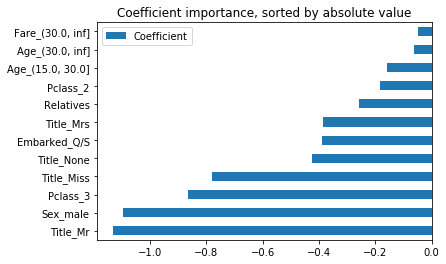

In [59]:
log_reg = best_estimators['LogisticRegression'].steps[-1][1]
feat_coef = pd.DataFrame({'Coefficient':log_reg.coef_.reshape(-1)}, index=X_train.columns)
feat_coef_abs_sorted = feat_coef.Coefficient.abs().sort_values(ascending = False)

feat_coef.loc[feat_coef_abs_sorted.index].plot(kind='barh')
plt.title('Coefficient importance, sorted by absolute value');

We see that Age and Fare are not good predictors, Relatives doesn't seem to be a good predictor either. Let'see if there is a significant change in accuracy predictions by dropping these features.

In [60]:
X_train.columns

Index(['Relatives', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Age_(15.0, 30.0]',
       'Age_(30.0, inf]', 'Fare_(30.0, inf]', 'Embarked_Q/S', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_None'],
      dtype='object')

In [61]:
cols_to_drop = ['Age_(15.0, 30.0]', 'Age_(30.0, inf]', 'Fare_(30.0, inf]', 'Relatives']
df_list = [X_train, X_test]

df_new_list = []
for df in df_list:
    df2 = df.copy()
    #append the dataframe with columns in cols_to_drop dropped
    df_new_list.append(df2.drop(cols_to_drop, axis=1))

X_train_reduced = df_new_list[0]
X_test_reduced = df_new_list[1]

In [62]:
results_df_reduced, best_estimators_reduced = multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train_reduced, y_train, X_test_reduced, y_test, grid_cv=5)
results_df_reduced

LogisticRegression DONE
KNeighborsClassifier DONE
DecisionTreeClassifier DONE
RandomForestClassifier DONE
AdaBoostClassifier DONE
LinearSVC DONE
SVC DONE
XGBClassifier DONE


,Best Parameters,All Best Parameters,Train Score Mean,CV Score Mean,Test Score Mean,CV Score STD,Fitting Time Mean
Estimator Name,,,,,,,
LogisticRegression,,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.806483,0.770139,0.769492,0.0763066,0.00585392
KNeighborsClassifier,,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.783022,0.768334,0.749153,0.086329,0.00145106
DecisionTreeClassifier,,"{'class_weight': None, 'criterion': 'gini', 'm...",0.820096,0.796784,0.79322,0.0564081,0.00110083
RandomForestClassifier,,"{'bootstrap': True, 'class_weight': None, 'cri...",0.818976,0.798396,0.79322,0.0587716,0.0111575
AdaBoostClassifier,,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.804249,0.773557,0.79661,0.0758657,0.0530355
LinearSVC,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.799034,0.785226,0.820339,0.0835778,0.0219645
SVC,,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.81991,0.805287,0.783051,0.0476527,0.00489662
XGBClassifier,,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.81991,0.805258,0.79322,0.0506092,0.0273682


The results are worse than before, showing that the Age, Fare and Relatives predictors are important to keep (or at least of them is).

## Model optimization

To optimize our models, we give different paramaters values to our function multi_estimators_gridsearch, which will assess which parameters are best by doing a grid search.

In [63]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# list of pre-processing transformer
preprocess_steps = [StandardScaler()]

# list of estimators to be trial
estimators = [LogisticRegression(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(),
              LinearSVC(),
              SVC(),
              XGBClassifier()
             ]

# dictionnaries of parameters grid
log_reg_params = {'penalty':['l2', 'l1'], 'C': np.logspace(-1,2,20)}
kneigh_params = {'n_neighbors':list(range(1,15))}
tree_param = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth':list(range(1,12))}
forest_param = {'n_estimators':[10,20,50,100], 'criterion':['gini', 'entropy'], 'max_depth':list(range(1,12))}
adaboost_param = {'n_estimators':[50,100], 'learning_rate':np.logspace(-2,2,20)}
lin_SVC_param = {'loss':['hinge', 'squared_hinge'], 'C': np.logspace(-2,2,20)}
SVC_param = {'kernel':['poly', 'rbf'], 'C': np.logspace(-2,2,20)}
xgb_clf_param = {'max_depth':[2,3,4,5], 'learning_rate':np.logspace(-2,2,10), 'n_estimators':[50,100,200]}

# list of dictionnay of parameters grid
params_list = [log_reg_params, kneigh_params, tree_param, forest_param, adaboost_param, lin_SVC_param, SVC_param, xgb_clf_param]

results_df, best_estimators = multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test, grid_cv=5)
results_df

LogisticRegression DONE
KNeighborsClassifier DONE
DecisionTreeClassifier DONE
RandomForestClassifier DONE
AdaBoostClassifier DONE
LinearSVC DONE
SVC DONE
XGBClassifier DONE


,Best Parameters,All Best Parameters,Train Score Mean,CV Score Mean,Test Score Mean,CV Score STD,Fitting Time Mean
Estimator Name,,,,,,,
LogisticRegression,C : 0.206913808111,"{'C': 0.20691380811147897, 'class_weight': Non...",0.808538,0.798701,0.80339,0.0737507,0.00210142
KNeighborsClassifier,n_neighbors : 11,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.813571,0.791869,0.776271,0.0420876,0.0018512
DecisionTreeClassifier,max_depth : 6,"{'class_weight': None, 'criterion': 'gini', 'm...",0.842467,0.791644,0.769492,0.0691206,0.00150099
RandomForestClassifier,max_depth : 11,"{'bootstrap': True, 'class_weight': None, 'cri...",0.849175,0.783561,0.8,0.0591597,0.0123082
AdaBoostClassifier,learning_rate : 0.483293023857,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.810779,0.80373,0.80339,0.0703856,0.108272
LinearSVC,C : 23.3572146909,"{'C': 23.357214690901213, 'class_weight': None...",0.803878,0.776835,0.759322,0.0827435,0.0305201
SVC,C : 2.06913808111,"{'C': 2.0691380811147901, 'cache_size': 200, '...",0.846753,0.795341,0.789831,0.0584171,0.0048532
XGBClassifier,n_estimators : 50,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.845077,0.801954,0.827119,0.0436521,0.0174614


We can also try to add an other pre-processing step : PolynomialFeatures(degree=2). This transformation will add the polynome of order 2, from our original features.

In [64]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# list of pre-processing transformer
preprocess_steps = [PolynomialFeatures(degree=2), StandardScaler()]

# list of estimators to be trial
estimators = [LogisticRegression(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(),
              LinearSVC(),
              SVC(),
              XGBClassifier()
             ]

# dictionnaries of parameters grid
log_reg_params = {'penalty':['l2', 'l1'], 'C': np.logspace(-1,2,20)}
kneigh_params = {'n_neighbors':list(range(1,15))}
tree_param = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth':list(range(1,12))}
forest_param = {'n_estimators':[10,20,50,100], 'criterion':['gini', 'entropy'], 'max_depth':list(range(1,12))}
adaboost_param = {'n_estimators':[50,100], 'learning_rate':np.logspace(-2,2,20)}
lin_SVC_param = {'loss':['hinge', 'squared_hinge'], 'C': np.logspace(-2,2,20)}
SVC_param = {'kernel':['poly', 'rbf'], 'C': np.logspace(-2,2,20)}
xgb_clf_param = {'max_depth':[2,3,4,5], 'learning_rate':np.logspace(-2,2,10), 'n_estimators':[50,100,200]}

# list of dictionnay of parameters grid
params_list = [log_reg_params, kneigh_params, tree_param, forest_param, adaboost_param, lin_SVC_param, SVC_param, xgb_clf_param]

results_df_poly2, best_estimators_poly2 = multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test, grid_cv=5)
results_df_poly2

LogisticRegression DONE
KNeighborsClassifier DONE
DecisionTreeClassifier DONE
RandomForestClassifier DONE
AdaBoostClassifier DONE
LinearSVC DONE
SVC DONE
XGBClassifier DONE


,Best Parameters,All Best Parameters,Train Score Mean,CV Score Mean,Test Score Mean,CV Score STD,Fitting Time Mean
Estimator Name,,,,,,,
LogisticRegression,C : 0.206913808111,"{'C': 0.20691380811147897, 'class_weight': Non...",0.835756,0.796951,0.80678,0.0545774,0.00930612
KNeighborsClassifier,n_neighbors : 10,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.81525,0.786783,0.772881,0.0562095,0.00430281
DecisionTreeClassifier,max_depth : 6,"{'class_weight': None, 'criterion': 'gini', 'm...",0.838745,0.803509,0.810169,0.0524044,0.00405262
RandomForestClassifier,max_depth : 6,"{'bootstrap': True, 'class_weight': None, 'cri...",0.843958,0.813706,0.820339,0.0522038,0.0574383
AdaBoostClassifier,learning_rate : 1.2742749857,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.827929,0.785226,0.80339,0.0719456,0.0685955
LinearSVC,C : 0.0263665089873,"{'C': 0.026366508987303583, 'class_weight': No...",0.837247,0.793645,0.816949,0.0634677,0.0147599
SVC,C : 3.35981828628,"{'C': 3.3598182862837809, 'cache_size': 200, '...",0.846755,0.800259,0.79661,0.0519268,0.0137092
XGBClassifier,n_estimators : 50,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.845263,0.800202,0.823729,0.0592535,0.0764008


We observe an higher accuracy in general, for the models with the polymial features, except for KNeighborsClassifier, which wasn't very good already without the polynomial preprocessing step.

Using the XGBClassifier with polynomial features give us a top 22% position on the leaderboard of the Kaggle competition.

### Voting Classifier

We built a large number of estimators, we could now try to benefit from all these estimators by creating a voting classifier, which will make a prediction by selecting the prediction the most frequent given from all our estimators.

In [65]:
from sklearn.ensemble import VotingClassifier

# we will select all estimators, except KNeighborsClassifier, which gave poor accuracy
estimators_keys = [key for key in best_estimators.keys() if key != 'KNeighborsClassifier']
estimators=[]
for key in estimators_keys:
    estimators.append((key, best_estimators[key]))
    estimators.append((key+'_poly', best_estimators_poly2[key]))

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_clf, X_train, y_train, cv=10)
print('scores mean : ', np.mean(scores))
print('scores std : ', np.std(scores))

scores mean :  0.798646383255
scores std :  0.0623643458161


These results are worse than for most of our single estimators, unfortunately.

We can also try a *soft* voting classifier, which use estimators who can predict a probability.

In [67]:
# we will select all estimators, except KNeighborsClassifier, which gave poor accuracy
estimators_keys = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'XGBClassifier']
estimators=[]
for key in estimators_keys:
    estimators.append((key, best_estimators[key]))
    estimators.append((key+'_poly', best_estimators_poly2[key]))

voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')

In [68]:
scores = cross_val_score(voting_clf_soft, X_train, y_train, cv=10)
print('scores mean : ', np.mean(scores))
print('scores std : ', np.std(scores))

scores mean :  0.806925071779
scores std :  0.063474821243


These results are not really convincing either.

# 4. Submission of results

Finally our best models seems to be AdaBoostClassifier, XGBClassifier, LogisticRegression, which seems to perform slighlty better if we take into account the polynomial features of second order.

In [69]:
best_estimator = best_estimators_poly2['XGBClassifier']
best_estimator.fit(X, y)
y_submission = best_estimator.predict(X_submission)

submission_df = pd.DataFrame({'PassengerId':X_submission.index, 'Survived':y_submission})
submission_df.to_csv('Data/submission.csv', index=False)